In [3]:
#| default_exp utils

In [4]:
#| export
from avcv._imports import *

## Memoize

In [5]:
#| export

ICACHE = dict()

def identify(x):
    '''Return an hex digest of the input'''
    return xxhash.xxh64(pickle.dumps(x), seed=0).hexdigest()

VERBOSE = False
AVCV_CACHE_DIR = '/tmp/avcv/'

def self_memoize(func):
    """
        Decorator for a function member of an object
    """
    @wraps(func)
    def _f(self, *args, **kwargs):
        
        if not hasattr(self, 'cache'):
            self.cache = {}
        ident_name = identify(args)
        timer = mmcv.Timer()
        if ident_name in self.cache:
            result = self.cache[ident_name]
            # print('[Cached]: {:0.2f}'.format(timer.since_start()))
        else:
            result = self.cache[ident_name] = func(self, *args, **kwargs)
            # print('[No cache]: {:0.6f}'.format(timer.since_start()))
        return result
    
    return _f

def memoize(func):

    '''Cache result of function call on disk
    Support multiple positional and keyword arguments'''
    @wraps(func)
    def memoized_func(*args, **kwargs):
        try:
            if 'cache_key' in kwargs:
                cache_key = kwargs['cache_key']
                
                func_id = identify((inspect.getsource(func)))+'_cache_key_'+str(kwargs['cache_key'])
                if VERBOSE:
                    logger.info(f'Use {cache_key=}->{func_id=}')
            else:
                func_id = identify((inspect.getsource(func), args, kwargs))
            cache_path = os.path.join(AVCV_CACHE_DIR, 'funcs', func.__name__+'/'+func_id)
            mmcv.mkdir_or_exist(os.path.dirname(cache_path))

            if (os.path.exists(cache_path) and
                    not func.__name__ in os.environ and
                    not 'BUST_CACHE' in os.environ):
                result = pickle.load(open(cache_path, 'rb'))
            else:
                result = func(*args, **kwargs)
                pickle.dump(result, open(cache_path, 'wb'))
            return result
        except (KeyError, AttributeError, TypeError, Exception) as e:
            logger.warning(f'Exception: {e}, use default function call')
            return func(*args, **kwargs)
    return memoized_func

def imemoize(func):
    """
        Memoize a function into memory, the function recaculate only 
        change when its belonging arguments change
    """
    @wraps(func)
    def _f(*args, **kwargs):

        timer = mmcv.Timer()

        ident_name = identify((inspect.getsource(func), args, kwargs))
        # if not ident_name in ICACHE:
        try:
            result = ICACHE[ident_name]
        except:
            result = func(*args, **kwargs)
            ICACHE[ident_name] = result
        return result
    return _f

In [6]:
#|hide
@memoize
def add(x):
    return x+1
add(1)

/home/anhvth8/.conda/envs/pt2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


2

In [7]:
#| export


def is_interactive():
    try:
        shell = get_ipython().__class__.__name__
        return True
    except:
        return False
    

def get_name(path):
    path = osp.basename(path).split('.')[:-1]
    return '.'.join(path)

def get_files(folder, ext='*'):
    return glob(osp.join(folder, ext))

def find_contours(thresh):
    """
        Get contour of a binary image
            Arguments:
                thresh: binary image
            Returns:
                Contours: a list of contour
                Hierarchy:

    """
    try:
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_SIMPLE)
        return contours, hierarchy[0]
    except:
        return None, None

def mkdir(path):
    os.makedirs(path, exist_ok=True)


def put_text(image, pos, text, color=(255, 255, 255)):
    return cv2.putText(image, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                       color, 2)


def video_to_images(input_video, output_dir=None, skip=1, rescale=None):
    """
        Extract video to image:
            inputs:
                input_video: path to video
                output_dir: default is set to video name
    """

    if output_dir is None:
        vname = get_name(input_video).split('.')[0]
        output_dir = osp.join('.cache/video_to_images/', vname)
        logger.info(f'Set output_dir = {output_dir}')

    video = mmcv.video.VideoReader(input_video)
    logger.info(f'Extracting video to images -> {output_dir}')
    pbar = mmcv.ProgressBar(video._frame_cnt)
    n_update = max(1, len(video)/1000)
    for i in range(0, len(video), skip):
        out_img_path = os.path.join(output_dir, f'{i:06d}' + '.jpg')

        if not osp.exists(out_img_path):
            try:
                img = video[i]
                if rescale is not None:
                    img = mmcv.imrescale(img, (rescale, rescale))

                mmcv.imwrite(img, out_img_path)
            except Exception as e:
                logger.warning(f"Cannot write image index {i}, exception: {e}")
                continue
        if i%n_update == 0:
            pbar.update(n_update)

@call_parse
def v2i(input_video:Param("", str), output_dir:Param("", str)=None, skip:Param("", int)=1, rescale:Param("", int)=None):
    return video_to_images(input_video, output_dir, skip, rescale)


In [8]:
#| export 
def images_to_video(
        images,
        out_path=None,
        fps: int = 30,
        no_sort=False,
        max_num_frame=10e12,
        resize_rate=1,
        with_text=False,
        text_is_date=False,
        verbose=True,
        resize=False,
        output_size=None
):
    assert output_size is not None
    if out_path is None:
        assert isinstance(
            images, str), "No out_path specify, you need to input a string to a directory"
        out_path = images+'.mp4'
    if isinstance(images, str) and os.path.isdir(images):
        images = glob(os.path.join(images, "*.jpg")) + \
            glob(os.path.join(images, "*.png")) + \
            glob(os.path.join(images, "*.jpeg"))

    def get_num(s):
        try:
            s = os.path.basename(s)
            num = int(''.join([c for c in s if c.isdigit()]))
        except:
            num = s
        return num
    
    def f(img_or_path):
        if isinstance(img_or_path, str):
            name = os.path.basename(img_or_path)
            img = mmcv.imread(img_or_path)
            img = cv2.resize(img, output_size)
            assert img is not None, img_or_path
            if with_text:
                if text_is_date:
                    name = name.split('.')[0].split('_')
                    f = float('{}.{}'.format(*name))
                img = put_text(img, (20, 20), name)
        else:
            img = img_or_path
        return img

    if not no_sort and isinstance(images[0], str):
        images = list(sorted(images, key=get_num))

    max_num_frame = int(max_num_frame)
    max_num_frame = min(len(images), max_num_frame)


    if output_size is None:
        h, w = mmcv.imread(images[0]).shape[:2]
        output_size = (int(w*resize_rate), int(h*resize_rate))
    if out_path.endswith('.mp4'):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, fps, output_size)
    elif out_path.endswith('.avi'):
        out = cv2.VideoWriter(
            out_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, output_size)
    else:
        raise NotImplementedError
    images = images[:max_num_frame]
    if isinstance(images[0], str) or resize:
        if verbose:
            logger.info('Read and resize images to shape {}'.format(output_size))
        images = multi_thread(f, images, verbose=verbose)
    
    if verbose:
        logger.info(f"Write video, output_size: {output_size}")
        pbar = mmcv.ProgressBar(len(images))

    n_update = max(len(images)//1000, 1)
    for i, img in enumerate(images):
        img = cv2.resize(img, output_size)
        out.write(img)
        if i % n_update == 0 and verbose:
            pbar.update(n_update)
    if verbose:
        logger.info("-> {}".format(osp.abspath(out_path)))
        
    out.release()
@call_parse
def av_i2v(
            images: Param("Path to the images folder or list of images"),
            out_path: Param("Output output video path", str)=None,
            fps: Param("Frame per second", int) = 30,
            no_sort: Param("Sort images", bool) = False,
            max_num_frame: Param("Max num of frame", int) = 10e12,
            resize_rate: Param("Resize rate", float) = 1,
            with_text: Param("Add additional index to image when writing vidoe", bool) = False,
            text_is_date: Param("Add additional index to image when writing vidoe", bool) = False,
            verbose:Param("Print...", bool)=True,
            output_size:Param("Print...", str)=None,
        ):
    if output_size is not None:
        output_size = [int(_) for _ in output_size.split(',') if _.isdigit()]
    return images_to_video(images, out_path, fps,
                           no_sort, max_num_frame, resize_rate, with_text,
                           text_is_date,verbose,output_size=output_size,
            )


## Video reader

In [47]:
mmcv.VideoReader??

Init signature: mmcv.VideoReader(filename, cache_capacity=10)
Source:        
class VideoReader:
    """Video class with similar usage to a list object.

    This video wrapper class provides convenient apis to access frames.
    There exists an issue of OpenCV's VideoCapture class that jumping to a
    certain frame may be inaccurate. It is fixed in this class by checking
    the position after jumping each time.
    Cache is used when decoding videos. So if the same frame is visited for
    the second time, there is no need to decode again if it is stored in the
    cache.

    Examples:
        >>> import mmcv
        >>> v = mmcv.VideoReader('sample.mp4')
        >>> len(v)  # get the total frame number with `len()`
        120
        >>> for img in v:  # v is iterable
        >>>     mmcv.imshow(img)
        >>> v[5]  # get the 6th frame
    """

    def __init__(self, filename, cache_capacity=10):
        # Check whether the video path is a url
        if not filename.startswith

In [96]:
#| export
def md5_from_str(s:str):
    import hashlib
    return hashlib.md5(s.encode('utf-8')).hexdigest()

class VideoReader:
    def __init__(self, file_name, scale=0.5, mode='gray', verbose=True):
        assert mode in ['rgb', 'gray']
        self.video = mmcv.VideoReader(file_name)
        hash_name = md5_from_str(osp.abspath(file_name))
        cache_file = osp.join(AVCV_CACHE_DIR, 'VideoReader/{}_{}.array'.format(hash_name, get_name(file_name)))
        
        self.height = int(self.video.height*scale)
        self.width = int(self.video.width*scale)
        self.mode = mode
        if osp.exists(cache_file):
            self._imgs = np.memmap(cache_file, mode='r', shape=(len(self.video), self.height, self.width, 1 if self.mode == 'gray' else 3))
        else:
            os.makedirs(osp.dirname(cache_file), exist_ok=True)
            try:
                self._imgs = np.memmap(cache_file, mode='w+', shape=(len(self.video), self.height, self.width, 1 if self.mode == 'gray' else 3))
                print('Expected size: {:0.2f} gb'.format(self._imgs.size/1024/1024/1024))
                pbar = range(len(self))
                if verbose: pbar = tqdm(pbar)
                for i in pbar:
                    img = self.video[i]
                    img = mmcv.imresize(img, (self.width, self.height))
                    if mode == 'gray' and len(img.shape) == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[...,None]
                    else:
                        img = img[...,::-1].copy()
                    self._imgs[i] = img
            except Exception as e:
                print(e)
                os.remove(cache_file)
        self.cache_file = cache_file
        
    def __len__(self):
        return len(self.video)
    
    def __getitem__(self, idx):
        return self._imgs[idx]
    

In [97]:
#| hide
v = VideoReader('/dms/dms/FDSP_data/220913/anhdv42_Sensing_Session1_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b.avi', mode='gray')

Expected size: 7.78 gb


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36257/36257 [01:43<00:00, 349.48it/s]


'/tmp/avcv/VideoReader/8ef84391c3a9204e4941b2e3556339ef_anhdv42_Sensing_Session1_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b.array'

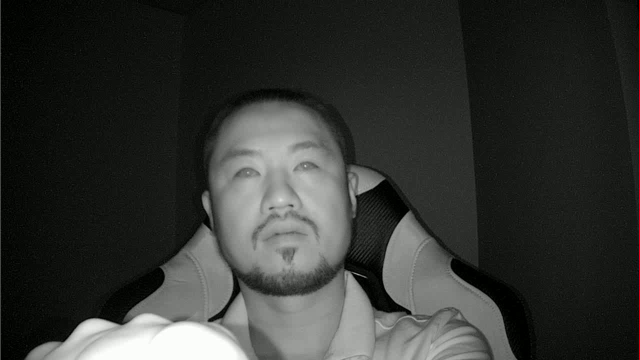

In [51]:
Image.fromarray(v[0])

## CLI examples
+ Download file given a google link

        gdown --help
        gdown "https://drive.google.com/file/d/1xOb92Yx3hoOsMsAiI2mnkcyoQatRQNBf/view?usp=sharing" test.mp3
        
This should return a openable mp3 file
+ Compose a video given a folder of images        

        i2v --help
        i2v PATH_TO_DIR out.mp4

+ Extract images given a video

        v2i --help # helper
        v2i test.mp4 test-img/

# Time logger

In [1]:
#| export

class TimeLoger:
    def __init__(self):
        self.timer = mmcv.Timer()
        self.time_dict = dict()

    def start(self):
        self.timer.start()

    def update(self, name):
        # assert not name in self.time_dict
        duration = self.timer.since_last_check()
        if name in self.time_dict:
            self.time_dict[name].append(duration)
        else:
            self.time_dict[name] = [duration]

    def __str__(self):
        total_time = np.sum([np.sum(v) for v in self.time_dict.values()])
        s = f"------------------Time Loger Summary : Total {total_time:0.2f} ---------------------:\n"
        for k, v in self.time_dict.items():
            average = np.mean(v)
            times = len(v)
            percent = np.sum(v)*100/total_time
            s += f'\t\t{k}:  \t\t{percent:0.2f}% ({average:0.4f}s) | Times: {times} \n'
        return s

In [2]:
#| export
def generate_tmp_filename():
    return tempfile.NamedTemporaryFile().name 
@memoize
def get_md5(video_path, os_system='linux'):
    tmp = tempfile.NamedTemporaryFile().name
    if os_system == 'linux':
        cmd = f'md5sum {video_path} > {tmp}'
        os.system(cmd)
        md5 = open(tmp).readlines()[0].split(' ')[0]
    else:
        os.system(f'md5 {video_path} > {tmp}')
        md5 = open(tmp).readlines()[0].split(' = ')[1][:-1]
    return md5


NameError: name 'memoize' is not defined

# Code utils

## Fast db

In [ ]:
#| export
# DB =  ipdb.set_trace

In [ ]:
#| export
def printc(module_or_func, verbose=True, return_lines=False):
    """
        Print code given a 
    """
    lines = inspect.getsource(module_or_func)
    if verbose:
        print(lines)
    if return_lines:
        return lines

In [3]:
!nbdev_export